<a href="https://colab.research.google.com/github/RockZhang29/EC601_Project/blob/main/%E2%80%9CEC500_PA3_SOLUTIONS_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization for Machine Learning PA 3

**due April 29th 2021**

This homework assignment investigates implementing *variance reduced* stochastic gradient descent. This is a relatively recent innovation (for example, see [this paper](https://papers.nips.cc/paper/2013/hash/ac1dd209cbcc5e5d1c6e28598e8cbbe8-Abstract.html) from NeurIPS 2013) on the standard SGD that is effective for minimizing *finite sum* objectives of the form:
$$
\mathcal{L}(w) = \frac{1}{N}\sum_{i=1}^N \ell(w,z_i)
$$
The original analyses only worked for smooth convex losses, although it has since been extended to the non-convex case (see [here](https://arxiv.org/abs/1807.01695), and [here](https://arxiv.org/abs/1806.07811) for two papers that independently and simultaneously co-discovered the optimal rates in the non-convex setting).

The basic algorithm is often called SVRG for stochastic variance-reduced gradient descent. In this homework, you will implement SVRG and test it on a linear classification task. In this setting, $N$ is the size of the training set and $\mathcal{L}(w)$ is the training loss.

This homework re-uses some code from the first programming assignment. In particular, you we will be comparing SVRG to the adaptive SGD algorithm from the first programming assigment. A working copy of that optimizer is included for you so you do not need to re-implement it.


There are **3** questions on this homework. The first two are mathematical, and the 3rd is an implementation question. You can write answers to the math question in this notebook. You can use standard latex environments, but you need to enclose them in dollar signs. For example:
$$
\begin{align*}
\|a-b\|^2&\ge 0\\
\|a\|^2-2\langle a,b\rangle+\|b\|^2&\ge 0\\
\|a\|^2 +\|b\|^2&\ge 2\langle a,b\rangle
\end{align*}
$$

To turn in this homework: download as .ipynb (File -> download as .ipynb). Make the filename YOURNAME_HW3.ipynb and send via email attachment to opt4mlclass+program3@gmail.com with your name in the subject line. Your submission should have **all cells run to completion**. When testing your code, you may wish to change the notebook to run only some subset of the training runs at the end: the reference solution takes between 20 and 30 minutes to finish all 6 runs in the last cell. To help you compare your performance, the output of the reference implementation has been left in this notebook. 

In [ ]:
#imports
import torch, torchvision
import torchvision.transforms as transforms
from torch.optim import Optimizer
import numpy as np
from matplotlib import pyplot as plt
from collections.abc import Iterable
import torch.nn as nn
import torch.nn.functional as F

$\newcommand{\L}{\mathcal{L}}$ $\newcommand{\E}{\mathbb{E}}$ $\newcommand{\R}{\mathbb{R}}$ $\newcommand{\bw}{\mathbf{w}}$ $\newcommand{\bv}{\mathbf{v}}$ $\newcommand{\bg}{\mathbf{g}}$ $\newcommand{\bx}{\mathbf{x}}% useful latex macro definitions$

**Question 1: Properties of Softmax and Cross-Entropy**

The *softmax* function converts a vector $v\in \R^n$ into another vector $S(v)=p\in \R^n$ such that $0\le p[i]<1$ for all $i$, and $\sum_{i=1}^n p[i] =1$. That is, $p$ represents a probability mass function over $n$ items. We'll call such vectors "probability vectors". The softmax function is defined by:
$$
S(v)[i] = \frac{\exp(v[i])}{\sum_{j=1}^d \exp(v[j])}
$$

The *cross-entropy* loss is a loss function for classification problems. Given a probability vector $p\in R^n$ and a true label $i\in\{1,\dots, n\}$, the cross-entropy is defined as:
$$
C(p,i)=-\log(p[i])
$$
Thus, the cross-entropy loss encourages the probability vector to place as much weight as possible on the "correct" class $i$.

In a classification problem in which examples $z$ are specified by $z=(\bx,y)$ where $\bx\in \R^d$ is a feature vector and $y$ is a label, we might have a model $M$ parameterized by a vector $\bw$ that outputs a vector $M(\bx,\bw)\in \R^n$. Then, the loss is defined by:
$$
\ell(w,z) = C(S(M(\bx,\bw)), y)
$$


**Question 1a** $\newcommand{\diag}{\text{diag}}$
Show that for any $i$, the function from $\R^n\to \R$ defined by $f(v) = C(S(\bv),i)$ satisfies $\nabla^2f(v) = \diag(S(v))-S(v)S(v)^\top$, where for a vector $k$, $\diag(k)$ is the diagonal matrix whose $i$th diagonal entry is $k[i]$.

SOLUTION
Without loss of generality, we may assume $i=1$ - the argument is completely symmetric with respect to the value of $i$. 

$$
\begin{align*}
f(v) &= -\log\left( \frac{\exp(v[i])}{\sum_{j=1}^d \exp(v[j])}\right)\\
&= -v[i] + \log\left(\sum_{j=1}^d \exp(v[j])\right)
\end{align*}
$$
Thus,
$$
\nabla f(v)[j] = -1[j=i] + \frac{\exp(v[j])}{\sum_{j=1}^d \exp(v[j])}
$$
where $1[j=i]$ is 1 if $j=i$ and zero otherwise. From this, we have:
$$
\nabla^2f(v)[j,k] = -\frac{\exp(v[j])\exp(v[k])}{\left(\sum_{j=1}^d \exp(v[j])\right)^2} + \frac{\exp(v[j])1[j=k]}{\sum_{j=1}^d \exp(v[j])}
$$


<br>

**Question 1b**

Show that for any $i$, the function from $\R^n\to \R$ defined by $f(v) = C(S(\bv),i)$ is convex and 1-smooth (hint, express smoothness/convexity in terms of maximum and minimum values for $w^\top\nabla^2 f(v)w$, and make sure to recall that $S(v)$ is a probability vector).

SOLUTION:

$f$ is convex if $w^\top \nabla^2 f(v)w\ge 0$ for all $w$. Let's verify this identity:
$$
\begin{align*}
w^\top \nabla^2 f(v) w &= w^\top(\diag(S(v)) - S(v)S(v)^\top w)w\\
&=\sum_{i=1}^d w[i]^2 S(v)[i] - \left(\sum_{i=1}^d w[i] S(v)[i]\right)^2
\end{align*}
$$
Now, by Cauchy-Schwarz:
$$
\begin{align*}
\left(\sum_{i=1}^d w[i] S(v)[i]\right)^2&=\left(\sum_{i=1}^d w[i] \sqrt{S(v)[i]}\sqrt{S(v)[i]}\right)^2\\
&\le \sum_{i=1}^d w[i]^2 S(v)[i]\sum_{i=1}^d  S(v)[i]\\
&=\sum_{i=1}^d w[i]^2 S(v)[i]
\end{align*}
$$
where the last line follows because $S(v)$ is a probability vector. Therefore $w^\top \nabla^2 f(v) w \ge 0$ and so $f$ is convex.

To show smoothness, we need to show $w^\top \nabla^2 f(v) w \le \|w\|^2$. For this:
\begin{align*}
w^\top \nabla^2 f(v) w &=\sum_{i=1}^d w[i]^2 S(v)[i] - \left(\sum_{i=1}^d w[i] S(v)[i]\right)^2\\
&\le\sum_{i=1}^d w[i]^2 S(v)[i]\\
&\le \sum_{i=1}^d w[i]^2\\
&=\|w\|^2
\end{align*}
where the second-to-last line follows since $S(v)[i]\in[0,1]$ since $S(v)$ is a probability vector.


<br>

**Question 1c**

Consider the linear model in which $w\in \R^{nd}$ represents a $n\times d$ matrix and $M(\bx,\bw) = \bw \bx\in \R^n$.  Suppose that the features $\bx$ satisfy $\|\bx\|\le 1$. Show that the loss $\ell(\bw,z)$ is convex and 1-smooth in $w$ for all $z$. Be careful - $\bw$ is a matrix so $\bw \bx$ is a matrix-vector product and not an inner-product! For this problem, you may use without proof the fact that if $\bw\in \R^{nd}$ has Euclidean norm $\|\bw\|\le \delta$, then then when viewed as a matrix in $\R^{n\times d}$, $\bw$ has operator norm at most $\delta$. (hint: first show that if $f(v)$ is a twice-differentiable convex and 1-smooth function and $A$ is a linear map with operator norm at most 1, then $g(w) = f(A(w))$ is convex and 1-smooth).

SOLUTION:

First, we show the hint. We have:
$$
\nabla g(w) = \nabla f(Aw) A
$$
So therefore again by chain rule:
$$
\nabla^2 g(w) = A^\top \nabla^2 f(Aw) A
$$
Now, for any vector $v$, $v^\top \nabla^2 g(w) v = (Av)^\top \nabla^2f(Aw) (Av)\ge 0$ since $f$ is convex, so therefore $g$ is convex. For smoothness, by smoothness of $f$ we have:
$$
v^\top \nabla^2 g(w) v= (Av)^\top \nabla^2f(Aw) (Av)\le \|Av\|^2
$$
now, since $A$ has operator norm at most 1, $\|Av\|^2\le \|v\|^2$ so $g$ is 1-smooth.

Now, to apply the hint, we need to express $\ell(\bw,z)$ as $f(A(w))$. Let's set $f$ to be the same function as from the previous part of this problem with $i=y$. Then we have $\ell(\bw,z)=f(\bw \bx)$. Thus, we need to show that $\bw\mapsto \bw \bx$ is a linear function with operator norm at most 1. First, we clearly have $(\bw +\bw')\bx = \bw\bx +\bw'\bx$ and $(c\bw)\bx=c(\bw \bx)$, so the function is linear. For operator norm, we are allowed to assume that, when viewed as a matrix, $\bw$ has operator norm at most $\|\bw\|$. Therefore $\|\bw\bx\|\le \|\bw\|\|\bx\|\le \|\bw\|$ since $\|\bx\|\le 1$. Thus the linear map $\bw\mapsto \bw\bx$ has operator norm at most 1, and so applying the hint shows the result.

$\newcommand{\L}{\mathcal{L}}$ $\newcommand{\E}{\mathbb{E}}$ $\newcommand{\R}{\mathbb{R}}$ $\newcommand{\bw}{\mathbf{w}}$ $\newcommand{\bv}{\mathbf{v}}$ $\newcommand{\bg}{\mathbf{g}}$ $\newcommand{\bx}{\mathbf{x}}$

**Question 2: SVRG on Hinge loss**

Suppose we used the *hinge loss* instead of the softmax and cross entropy loss to train the classifier. The hinge loss would take the form:
$$
\ell(\bw, (\bx,y)) = \max_{i\ne y} 1-M(\bx,\bw)[i] +M(x,\bw)[y]
$$
Consider the standard non-adaptive SVRG algorithm discussed in lecture. In the following questions, you may use the fact that with the linear model $M(\bx,\bw)=\bw\bx$, and assuming $\|\bx\|\le 1$, $\ell(\bw,z)$ is convex and 1-Lipschitz.

**Question 2a:**

When using the softmax and cross entropy loss, we expect the SVRG algorithm to convergence asymptotically faster than SGD. However, this might not be true with the hinge loss. Why not?


ANSWER:
Since $\ell$ is not smooth, the SVRG analysis does not apply.


<br>
Even though SVRG might not converge faster than SGD, it will at least converge. The next problems walk you through showing this.

**Question 2b:**

Let $\bg_t=\nabla \ell(\bw_t,z_t) -\nabla \ell(\bv,z_t) + \nabla \L(\bv)$ be the variance-reduced gradient estimate for SVRG. Show that
$$
\|\bg_t\|^2 \le 9
$$

SOLUTION:
Note that
$$
\|a+b+c\|^2=\|a\|^2+2\langle a, b\rangle + \|b\|^2+2\langle b,c\rangle + \|c\|^2+2\langle a,c\rangle
$$ Now, if $\|a\|\le 1$, $\|b\|\le 1$ and $\|c\|\le 1$, we have $\|a+b+c\|^2\le 9$.
Using this identity with $a=\nabla \ell(\bw_t,z_t)$, $b=\nabla \ell(\bv,z_t)$ and $c=\nabla \L(\bv)$, we have
$$
\|\bg_t\|^2\le 9
$$
as desired.

<br>

**Question 2c:**

Show that with learning rate $\eta=\frac{\|\bw_1-\bw_\star\|}{\sqrt{T}}$, SVRG satisfies:
$$
\sum_{t=1}^T \E[\L(\bw_t)-\L(\bw_\star)]\le O\left(\|\bw_1-\bw_\star\|\sqrt{T}\right)
$$

SOLUTION:
First, let's verify that $\E[\bg_t]=\nabla \L(\bw_t)$ still. This turns out not to have depended on smoothness in our initial analysis of SVRG:
$$
\E[\bg_t] = \nabla \L(\bw_t) -\nabla \L(\bv)+\nabla \L(\bv)=\nabla \L(\bw_t)
$$
Now, we proceed as in our analysis of SGD for convex and Lipschitz losses:
$$
\begin{align*}
\|\bw_{t+1} - \bw_\star\|^2&\le \|\bw_t-\bw_\star - \eta \bg_t\|^2\\
&\le \|\bw_t-\bw_\star\|^2 - 2\eta\langle \bg_t, \bw_t-\bw_\star\rangle + \eta^2\|\bg_t\|^2\\
\langle \bg_t,\bw_t-\bw_\star\rangle &\le \frac{\|\bw_t-\bw_\star\|^2-\|\bw_{t+1}-\bw_\star\|^2}{2\eta} +\frac{\eta\|\bg_t\|^2}{2}\\
&\le \frac{\|\bw_t-\bw_\star\|^2-\|\bw_{t+1}-\bw_\star\|^2}{2\eta} +\frac{9\eta}{2}\\
\E[\langle \nabla \L(\bw_t),\bw_t-\bw_\star\rangle]&\le \E\left[ \frac{\|\bw_t-\bw_\star\|^2-\|\bw_{t+1}-\bw_\star\|^2}{2\eta} +\frac{9\eta}{2}\right]\\
\E[\L(\bw_t)-\L(\bw_\star)]&\le \E\left[ \frac{\|\bw_t-\bw_\star\|^2-\|\bw_{t+1}-\bw_\star\|^2}{2\eta} +\frac{9\eta}{2}\right]\\
\sum_{t=1}^T \E[\L(\bw_t)-\L(\bw_\star)]&\le \E\left[\frac{\|\bw_1-\bw_\star\|^2}{\eta} + \frac{9 \eta T}{2}\right]
\end{align*}
$$
Now, the conclusion follows from the setting of $\eta$


In [ ]:
class SGD_adaptive(Optimizer):
  def __init__(self, params, lr=1.0):
    super(SGD_adaptive, self).__init__(params, {'lr': lr})

    for group in self.param_groups:
      for param in group['params']:
        state = self.state[param]
        state['step'] = 0

        # make a dictionary entry for Gt. It is just a 1-D vector (a scalar).
        # device=p.device tells pytorch to allocate the memory for Gt on the 
        # same device (e.g. CPU or GPU) as the data for the variable p.
        state['Gt'] = torch.zeros(1, device=param.device)

  @torch.no_grad()
  def step(self, closure=None):
    loss = None
    if closure is not None:
      with torch.enable_grad():
        loss = closure()

    for group in self.param_groups:
      lr = group['lr']
      for param in group['params']:
        if param.grad is None:
          continue

        # Update the iteration counter (again, this is not actually used in this algorithm)
        state = self.state[param]
        state['step'] += 1
        step = state['step']

        grad = param.grad

        state['Gt'].add_(torch.norm(grad)**2)
        
        param.addcdiv_(grad, torch.sqrt(state['Gt']), value=-lr)


**SVRG with adaptive learning rates**

The SVRG algorithm we discussed in class performs the following scheme:
1. generate a "checkpoint gradient" $\nabla \mathcal{L}(v)$ at a point $v$ using a full pass over the training set.
2. Run a full pass over the training set using SGD update with the "variance reduced" gradients:
$$
g_t = \nabla \ell(w_t, z_t) - \nabla \ell(v, z_t) + \nabla \mathcal{L}(v)
$$
3. Set a new checkpoint parameter $v$ to be the *average* of the iterates produced in step 2, then go back to step 1 and repeat.

We will call the full passes "epochs", and we will say that that we are in an "SGD phase" if the epoch is happening in step 2, vs a "checkpoint phase" if the epoch is happening in step 1.

You will produce a modified version of SVRG that incorporates a few tricks to improve the performance in practice.
* Your implementation will allow for larger batch-sizes, so the variance-reduced gradient updates will be:
$$
g_t = \frac{1}{B}\sum_{i=1}^B\nabla \ell(w_t, z_{t,i}) - \frac{1}{B}\sum_{i=1}^B\nabla \ell(v, z_{t,i}) + \nabla \mathcal{L}(v)
$$
This part does not actually require any work on your part - pytorch will automatically provide you with the minibatch gradient values $\frac{1}{B}\sum_{i=1}^B\nabla \ell(w_t, z_{t,i})$ and $\frac{1}{B}\sum_{i=1}^B\nabla \ell(v, z_{t,i})$.
* Instead of first generating a checkpoint gradient, you will first perform a full pass of ordinary SGD without using the variance reduced gradients. Then you will set the checkpoint $v$ to be the last iterate produced during this full pass, compute a checkpoint gradient and continue using the variance-reduced gradients.
* After each full pass over the training set in the SGD phase, you will set the next checkpoint $v$ to be the last iterate rather than the average of the iterates.
* You will incorporate adaptive learning rates:
$$
\eta_t = \frac{lr}{\sqrt{\sum_{\tau=1}^t \|g_\tau\|^2}}
$$
where $lr$ is a user-specified constant. Notice that the $g_t$ here is the variance-reduced gradient estimate rather than the simple minibatch-estimate used when computing the adaptive learning rate we discussed in lecture and implemented in the `SGD_adaptive` class provided above in this homework.

**Question 2: implementing SVRG**
Please read the provided code for the SVRG optimizer carefully. Then, implement 3 functions to complete the optimizer. These are:

* `checkpoint_update`
* `vr_update`
* `process_checkpoint_for_SGD_phase`

Two functions of note in this optimizer are `step` and `switch_checkpoint_phase`. When the optimizer is used, every iteration the trainer will call `step` just as with any other optimizer. However, after each full pass over the training set (that is, after each epoch), the trainer must also call `switch_checkpoint_phase`. `switch_checkpoint_phase` is responsible for setting up the optimizer to go into the next phase, either an SGD phase or a checkpoint phase.

During the `step` function, the optimizer does one of three things:
* If this is during the first epoch, we perform an update identical to the standard adaptive SGD update, as outlined above. This part has been implemented for you below.
* If this step happens during an SGD phase, the function `vr_update` is called. This function (which you need to write) will calculate the variance-reduced gradient estimate, update the adaptive learning rate, and perform the SGD step.
* If this step happens during a checkpoint phase, the function `checkpoint_update` is called. This function is partially responsible for computing the new checkpoint gradient $\nabla \mathcal{L}(v)$.

During the `switch_checkpoint_phase` function, the optimizer also does one of two things:
* If the next epoch will be a checkpoint phase, the values in the parameter $w$ (or `param` as it is called in the code) are copied over into the checkpoint parameter $v$ (or `ckpt_param` as it is called in the code).
* If the next epoch will be an SGD phase, then `process_checkpoint_for_SGD_phase` is called. This function performs any final processing you might need in order to make the value of `state[param]['checkpoint_gradient']` contain the checkpoint gradient $\nabla \mathcal{L}(v)$.

So, during a "checkpoint phase", the operation is essentially the following:

For minibatch in the training set, compute the minibatch gradient at the checkpoint and call `checkpoint_update`. The gradient at the checkpoint is stored in `ckpt_grad`. After iterating through all the minibatches in the training set (i.e. after the epoch is finished), call `process_checkpoint_for_SGD_phase`. At the end of this process, `state[param]['checkpoint_gradient']` needs to contain the checkpoint gradient $\nabla \mathcal{L}(v)$.





In [ ]:
class SVRG(Optimizer):
  def __init__(self, params, lr=1.0):
    try:
      checkpoints = params[0].get("checkpoints", None)
    except:
      raise TypeError("params argument of SVRG is not a dict-like object.")
    
    super(SVRG, self).__init__(params, {'lr': lr, 'checkpoints':None})

    if checkpoints is None:
      raise SyntaxError("params argument of SVRG should have a 'checkpoints' field.")

    # This variable is used to determin the total number of minibatches in one
    # epoch. If the training set has size N and the batches have B examples per
    # batch, then this number will be N/B. However, the optimizer does not know
    # either N or B. So this will simply be a counter that will increment every
    # iteration. When the epoch is finished, the training function will have to
    # tell the optimizer that it is over, at which point the value of this variable
    # will be the correct value.
    self.N_over_batch_size = 0
    # this next variable is used for debugging: it will check if the batch
    # size has changed or if the N_over_batch_size variable is being updated
    # differently in different phases.
    self.prev_N_over_batch_size = None

    # flags indicating which phase we are in.
    # initial_phase=True means we are in the first epoch, in which we run ordinary
    # adaptive SGD without any variance reduction.
    self.initial_phase=True
    # checkpoint_phase indicates whether this epoch is used to compute a
    # checkpoint gradient or to perform SGD with variance-reduced gradient estimates.
    self.checkpoint_phase = False

    for group in self.param_groups:
      for p in group['params']:
        state = self.state[p]
        state['step'] = 0
        state['checkpoint_grad'] = torch.zeros_like(p, memory_format=torch.preserve_format)
        state['Gt'] = torch.zeros(1, device=p.device)


  def process_checkpoint_for_SGD_phase(self, param, state):
    # this function should compute any post-processing (if necessary) to
    # leave state['checkpoint_grad'] holding a value equal to the average of
    # all the checkpoint gradients observed over the course of last epoch.
    # arguments:
    # param: parameter value (w)
    # state: value for self.state[param].

    ## YOUR CODE HERE ##
    state['checkpoint_grad'].div_(self.N_over_batch_size)
    
    pass

  def checkpoint_update(self, param, ckpt_grad, state):
    # this function should perform some update using the gradient at the checkpoint
    # in order to eventually have state['checkpoint_grad'] contain the average
    # of all the ckpt_grad's encountered over this epoch.
    # Note that at the end of the epoch, process_checkpoint_for_SGD_phase
    # will be called, so that you can do some final processing to compute the
    # average if you need to.
    # arguments:
    # ckpt_grad: gradient at checkpoint (\nabla \ell(v, z_t))
    # param: parameter value (w)
    # state: value for self.state[param].

    ## YOUR CODE HERE ##
    state['checkpoint_grad'].add_(ckpt_grad)


  def vr_update(self, grad, ckpt_grad, param, state):
    # this function should compute the variance-reduced gradient estimate g_t,
    # update the adaptive learning rate, and compute an SGD update.
    # arguments:
    # grad: gradient at param (\nabla \ell(w_t, z_t))
    # ckpt_grad: gradient at checkpoint (\nabla \ell(v, z_t))
    # param: parameter to update (w_t)
    # state: value for self.state[param].

    vr_grad = state['checkpoint_grad'] + grad - ckpt_grad

    state['Gt'].add_(torch.norm(vr_grad)**2)
    param.addcdiv_(vr_grad, torch.sqrt(state['Gt']), value=-lr)


  @torch.no_grad()
  def step(self, closure=None):
    loss = None
    epsilon = 1e-8
    if closure is not None:
      with torch.enable_grad():
        loss = closure()
    self.N_over_batch_size += 1
    for group in self.param_groups:
      lr = group['lr']

      for param, ckpt_param in zip(group['params'], group['checkpoints']):
        if param.grad is None:
          continue
        
        assert ckpt_param.grad is not None, "checkpoint should have gradients!"
        ckpt_grad = ckpt_param.grad
        grad = param.grad

        state = self.state[param]
        if self.initial_phase:
          state['Gt'].add_(torch.norm(grad)**2)
          param.addcdiv_(grad, torch.sqrt(state['Gt']), value=-lr)

        elif self.checkpoint_phase:
          self.checkpoint_update(param, ckpt_grad, state)
        
        else:
          # Make sure that the smoothness properties underyling SVRG hold (you showed that the loss is 1-smooth in Question 1)
          assert torch.linalg.norm(grad - ckpt_grad) < 1.001*(0.00001+torch.linalg.norm(param - ckpt_param)) #small values added for floating point rounding errors.

          self.vr_update(grad, ckpt_grad, param, state)
          
           
  @torch.no_grad()
  def switch_checkpoint_phase(self):
    """switches checkpoint_phase to opposite value. performs any necessary
    initialization of variables for this phase."""

    # feel free to uncomment these print statement to help debug
    # if self.checkpoint_phase:
    #   print("next epoch will be an SGD epoch")
    # else:
    #   print("next epoch will be a checkpoint epoch")

    self.checkpoint_phase = not self.checkpoint_phase

    # This is just to check for potential errors in counting the number
    # of iterations in an epoch.
    if self.prev_N_over_batch_size is not None:
      assert self.prev_N_over_batch_size == self.N_over_batch_size
    self.prev_N_over_batch_size = self.N_over_batch_size


    if self.checkpoint_phase:
      for group in self.param_groups:
        for param, ckpt_param in zip(group['params'], group['checkpoints']):
          # verify that the parameter has been updated in the SGD phase:
          assert torch.linalg.norm(param - ckpt_param) > 0.00001

          # copy over the final iterate produced by SGD into the checkpoint values,
          # and zero out the checkpoint gradient in preparation for computing a new
          # checkpoint gradient in the upcoming checkpoint phase.
          state = self.state[param]
          ckpt_param.copy_(param)
          state['checkpoint_grad'].zero_()
    else:
      #feel free to uncomment this print statement to help debug
      # print("n over batch size: ", self.N_over_batch_size)
      for group in self.param_groups:
        for param, ckpt_param in zip(group['params'], group['checkpoints']):
          # verify that no changes to the parameter occured during the checkpoint phase
          assert torch.linalg.norm(param - ckpt_param) < 0.0001

          state = self.state[param]

          self.process_checkpoint_for_SGD_phase(param, state)


    self.N_over_batch_size = 0
    self.initial_phase=False


  # The following two functions make sure that the gradients are computed
  # properly at the checkpoint parameter values. It is not important to
  # read or understand them. 
  def zero_grad(self, set_to_none: bool = False):
    self.zero_checkpoint_grad(set_to_none)
    super(SVRG, self).zero_grad(set_to_none)

  def zero_checkpoint_grad(self, set_to_none: bool = False):
    """Sets the gradients of all checkpoints to zero."""
    if not hasattr(self, "_zero_grad_profile_name"):
      self._hook_for_profile()
    with torch.autograd.profiler.record_function(self._zero_grad_profile_name):
      for group in self.param_groups:
        for p in group['checkpoints']:
          if p.grad is not None:
            if set_to_none:
              p.grad = None
            else:
              if p.grad.grad_fn is not None:
                p.grad.detach_()
              else:
                p.grad.requires_grad_(False)
              p.grad.zero_()

See https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py for some similar example of how to set up the process below, from which much of this was copied.

In [ ]:
## These commands create two pytorch "DataLoader" objects, one for training
# data and one for testing data.
# A DataLoader object is essentially a list of training/testing examples with
# some extra code attached by pytorch that can send the data to GPUs and other
# useful things.

# The following three commands produce a torchvision dataset object for both
# training and testing data on the CIFAR10 dataset, which is a dataset of images.
# these objects are like lists of vectors (the "transform" specifies a function
# that converts images to vectors").
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
CIFAR_train = torchvision.datasets.CIFAR10(root='CIFAR10/', train=True, download=True, transform=transform)
CIFAR_test = torchvision.datasets.CIFAR10(root='CIFAR10/', train=False, transform=transform)


Files already downloaded and verified


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)


cuda:0


In [ ]:
# We will consider a linear classifier. The classifier will first normalize the features to have norm 1
# and then multiply by a matrix w to obtain scores for each class, which will eventually
# be evaluated using softmax and cross-entropy loss.
class LinearClassifier(nn.Module):
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(32*32*3, 10, bias=False)
        
    def forward(self, x):
        x = self.flatten(x)
        x = x/(torch.linalg.norm(x)+0.00001)
        logits = self.linear(x)
        return logits

In [ ]:
## Please read this code to understand how the two gradients are computed for SVRG. ##


def train_model(train_loader, device, lr, num_epochs, svrg=False):
  '''
  Trains a linear classifier on CIFAR10 data.

  args:
    train_loader: pytorch DataLoader object that provides the training examples.
    device: pytorch device to use (e.g. a GPU).
    lr: learning rate.
    num_epochs: number of epochs to train for.
    svrg: flag specifying whether to use SVRG vs SGD.

  returns:
    model, losses
    model: the trained pytorch model object.
    losses: the sequence of losses produced over training.
  '''

  model = LinearClassifier()
  model.to(device)
  losses = []

  if svrg:
    checkpoint_model = LinearClassifier()
    checkpoint_model.load_state_dict(model.state_dict())
    checkpoint_model.to(device)

    checkpoint_param = list(checkpoint_model.parameters())[0]
    model_param = list(model.parameters())[0]
    with torch.no_grad():
      checkpoint_param.copy_(model_param)


  # define \ell as the cross-entropy function.
  # this function as implemented in pytorch actually combines both the softmax
  # and the cross entropy function into one. As a result, it is
  # is non-negative, smooth, Lipschitz, and convex in its argument, which
  # are the predicted scores for various classes output by some model.
  cross_entropy_loss = torch.nn.CrossEntropyLoss()

  if svrg:
    # generate a second model to hold the checkpoint parameters and initialized the SVRG optimizer.
    group = [{'params': model.parameters(), 'lr': lr, 'checkpoints': list(checkpoint_model.parameters())}]
    optimizer = SVRG(group)
  else:
    optimizer = SGD_adaptive(model.parameters(), lr)


  average_loss = 0.0

  for epoch in range(num_epochs):
    # iterate over training set.

    for i, data in enumerate(train_loader):
      # unpack the example data: inputs is a batch of images,
      # labels is a batch of labels.
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # pytorch will keep details from old gradients around in case you are going
      # to differentiate something else. We therefore need to delete this old
      # data before computing the loss so that we only have the gradient
      # for this iteration.
      optimizer.zero_grad()

      predicted_labels = model.forward(inputs)
      loss = cross_entropy_loss(predicted_labels, labels)

      # tell pytorch to compute some gradients
      loss.backward()

      if svrg:
        checkpoint_predictions = checkpoint_model.forward(inputs)

        # make sure that the predictions produced by the checkpoint model are close to the predictions produced by the main model.
        # If this is false, this suggests that the checkpoint model is being evaluated on different data than the main model
        assert torch.max(torch.linalg.norm(checkpoint_predictions - predicted_labels,dim=0)) < 0.0001+torch.linalg.norm(checkpoint_param - model_param) # add small value for floating point rounding.

        checkpoint_loss = cross_entropy_loss(checkpoint_predictions, labels)
        checkpoint_loss.backward()

      optimizer.step()

      

      average_loss += (loss.item() - average_loss)/(i+1)
      losses.append(loss.item())


    print('[After epoch %d] loss: %.3f' %
          (epoch + 1, average_loss))
    average_loss = 0.0

    if svrg:
      optimizer.switch_checkpoint_phase()

      if optimizer.checkpoint_phase:
        # if we are about to enter a checkpoint phase, the checkpoint model and the main model should be at the same parameter value
        assert torch.linalg.norm(checkpoint_param - model_param) < 0.0001
      else:
        # even if we are about to enter an SGD phase, the checkpoint model and the main model should be at the same parameter value.
        # This "if/else" statement is simply to help debug in a more fine-grained manner as it pins down the issue to which
        # phase caused the problem.
        assert torch.linalg.norm(checkpoint_param - model_param) < 0.0001

  print('Finished Training')

  return model, losses


In [ ]:
def get_trainloader(batch_size):
  trainloader = torch.utils.data.DataLoader(CIFAR_train, batch_size=batch_size,
                                            shuffle=True)
  return trainloader


**Testing the implementation**
Now, for each learning rate in [10, 100, 1000] we will check the performance of both the adaptive SGD and your SVRG implementation. These learning rates are chosen such that SGD has its best performance at learning rate 100. The batch-size will be set to 5, the number of points in the training set is 50000, and the number of epochs is 11.

* While testing to make sure you pass the various asserts or other debugging, you may want to change the batch size or the number of epochs, but make sure you change it back.
* The best performance for SVRG should be with learning rate 1000.

In [ ]:
batch_size = 5
num_epochs = 11
lr_list = [10.0, 100.0, 1000.0]
trained_models_svrg = {}
trained_models_sgd = {}
losses_svrg = {}
losses_sgd = {}
for lr in lr_list:
  print("Training models with learning rate: {}".format(lr))
  num_epochs = 11
  trainloader = get_trainloader(batch_size)
  print("Training SVRG")
  trained_models_svrg[lr], losses_svrg[lr] = train_model(trainloader, device, lr=lr, num_epochs=num_epochs, svrg=True)
  print("Training SGD")
  trained_models_sgd[lr], losses_sgd[lr] = train_model(trainloader, device, lr=lr, num_epochs=num_epochs, svrg=False)

Training models with learning rate: 10.0
Training SVRG
[After epoch 1] loss: 1.851
[After epoch 2] loss: 1.803
[After epoch 3] loss: 1.790
[After epoch 4] loss: 1.779
[After epoch 5] loss: 1.771
[After epoch 6] loss: 1.766
[After epoch 7] loss: 1.760
[After epoch 8] loss: 1.754
[After epoch 9] loss: 1.751
[After epoch 10] loss: 1.746
[After epoch 11] loss: 1.742
Finished Training
Training SGD
[After epoch 1] loss: 1.849
[After epoch 2] loss: 1.796
[After epoch 3] loss: 1.781
[After epoch 4] loss: 1.772
[After epoch 5] loss: 1.766
[After epoch 6] loss: 1.760
[After epoch 7] loss: 1.756
[After epoch 8] loss: 1.752
[After epoch 9] loss: 1.750
[After epoch 10] loss: 1.746
[After epoch 11] loss: 1.744
Finished Training
Training models with learning rate: 100.0
Training SVRG
[After epoch 1] loss: 1.845
[After epoch 2] loss: 1.737
[After epoch 3] loss: 1.694
[After epoch 4] loss: 1.686
[After epoch 5] loss: 1.679
[After epoch 6] loss: 1.674
[After epoch 7] loss: 1.671
[After epoch 8] loss: 1.

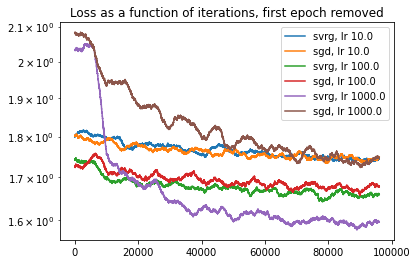

In [ ]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
for lr in lr_list:
  smoothed_svrg = running_mean(losses_svrg[lr][10000:], 4000)
  smoothed_sgd = running_mean(losses_sgd[lr][10000:], 4000)
  plt.plot(smoothed_svrg, label='svrg, lr {}'.format(lr))
  plt.plot(smoothed_sgd, label='sgd, lr {}'.format(lr))
plt.yscale('log')
plt.title('Loss as a function of iterations, first epoch removed')
plt.legend()

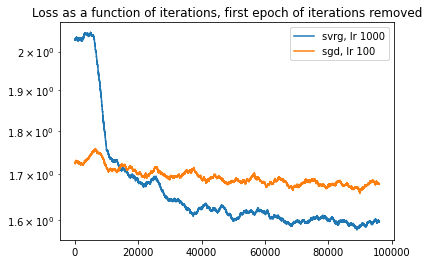

In [ ]:
# just plot the best values:
smoothed_svrg = running_mean(losses_svrg[1000][10000:], 4000)
smoothed_sgd = running_mean(losses_sgd[100][10000:], 4000)
plt.plot(smoothed_svrg, label='svrg, lr {}'.format(1000))
plt.plot(smoothed_sgd, label='sgd, lr {}'.format(100))
plt.yscale('log')
plt.title('Loss as a function of iterations, first epoch of iterations removed')
plt.legend()